In [2]:
import sys
if '../' not in sys.path:
    sys.path.append('../')

import seaborn as sns
import pandas as pd
import numpy as np

from typing import Callable

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.model_selection import ParameterGrid
from sklearn.cluster import AffinityPropagation, KMeans
from sklearn.mixture import GaussianMixture
from matplotlib import pyplot as plt

from src.clustering import GeneralClustererFinder

In [3]:
COLORS = ["red", "green", "blue", "yellow", "orange", "purple"]

# Reading the data

For better clustering exploration I will merge the two labeled data files we currently have and merge them into a 2d series.

Since we cannot meaningfully merge two entries from different repeated experiments, I will use average VALUE of a given compound in an experiment as one dimension.

In [4]:
data_ros1 = pd.read_excel("../data/raw/ROS1_DTT_fanonymised_limited.xlsx")
data_ros2 = pd.read_excel("../data/raw/ROS2_HRP anonymised limited.xlsx")

In [5]:
data_ros1["id"] = (data_ros1["DTT  - compound ID"].astype(str) + data_ros1["Barcode assay plate"].str[:-4]) + data_ros1["Barcode assay plate"].str[-1]
data_ros1.head()

,DTT - compound ID,Barcode assay plate,WELL,row,column,VALUE,Well type,CONTROL OUTLIER,CTRL NEG Mean(VALUE),CTRL NEG Standard deviation(VALUE),...,CMPD Mean(VALUE),CMPD Standard deviation(VALUE),Z',Z' robust,% ACTIVATION,Z score,ACTIVITY (above 30%),ACTIVITY (Z score above 3),Transfer Status,id
0,102092,B1007L2002L03DTT2,P22,16,22,27290,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,-0.808767,-0.230132,INACTIVE,Z score below 3,OK,102092B1007L2002L032
1,102091,B1007L2002L03DTT2,N22,14,22,26992,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,-1.031746,-0.256899,INACTIVE,Z score below 3,OK,102091B1007L2002L032
2,102090,B1007L2002L03DTT2,L22,12,22,27213,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,-0.866382,-0.237048,INACTIVE,Z score below 3,OK,102090B1007L2002L032
3,102089,B1007L2002L03DTT2,J22,10,22,48548,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,15.097574,1.679343,INACTIVE,Z score below 3,OK,102089B1007L2002L032
4,102088,B1007L2002L03DTT2,H22,8,22,28456,CMPD,NaN,28370.875,1007.138182,...,29852.036932,11132.901953,0.908973,0.909246,0.063695,-0.125397,INACTIVE,Z score below 3,OK,102088B1007L2002L032


In [6]:
data_ros2["id"] = (data_ros2["HRP - compound ID"].astype(str) + data_ros2["Barcode assay plate"].str[:-4]) + data_ros2["Barcode assay plate"].str[-1]
data_ros2.head()

,HRP - compound ID,Barcode assay plate,WELL,row,column,VALUE,CONTROL OUTLIER,CTRL NEG Mean(VALUE),CTRL NEG Standard deviation(VALUE),CTRL NEG Median(VALUE),CTRL POS Mean(VALUE),CTRL POS Standard deviation(VALUE),CTRL POS Median(VALUE),Z',Z' robust,% ACTIVATION,ACTIVITY,Destination Plate Barcode,Transfer Status,id
0,102092,B1007L2002L03HRP1,P22,16,22,0.104,NaN,0.100875,0.001857,0.1000,0.589250,0.016180,0.590,0.889198,0.889565,0.639877,INACTIVE,NaN,OK,102092B1007L2002L031
1,102092,B1007L2002L03HRP2,P22,16,22,0.105,NaN,0.102563,0.002279,0.1025,0.589063,0.016126,0.591,0.886500,0.886965,0.501028,INACTIVE,NaN,OK,102092B1007L2002L032
2,102091,B1007L2002L03HRP1,N22,14,22,0.102,NaN,0.100875,0.001857,0.1000,0.589250,0.016180,0.590,0.889198,0.889565,0.230356,INACTIVE,NaN,OK,102091B1007L2002L031
3,102091,B1007L2002L03HRP2,N22,14,22,0.111,NaN,0.102563,0.002279,0.1025,0.589063,0.016126,0.591,0.886500,0.886965,1.734327,INACTIVE,NaN,OK,102091B1007L2002L032
4,102090,B1007L2002L03HRP1,L22,12,22,0.102,NaN,0.100875,0.001857,0.1000,0.589250,0.016180,0.590,0.889198,0.889565,0.230356,INACTIVE,NaN,OK,102090B1007L2002L031


In [7]:
combined_df = pd.merge(data_ros1, data_ros2, on="id")
combined_df.head()

,DTT - compound ID,Barcode assay plate_x,WELL_x,row_x,column_x,VALUE_x,Well type,CONTROL OUTLIER_x,CTRL NEG Mean(VALUE)_x,CTRL NEG Standard deviation(VALUE)_x,...,CTRL NEG Median(VALUE)_y,CTRL POS Mean(VALUE)_y,CTRL POS Standard deviation(VALUE)_y,CTRL POS Median(VALUE)_y,Z'_y,Z' robust_y,% ACTIVATION_y,ACTIVITY,Destination Plate Barcode,Transfer Status_y
0,102092,B1007L2002L03DTT2,P22,16,22,27290,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.501028,INACTIVE,NaN,OK
1,102091,B1007L2002L03DTT2,N22,14,22,26992,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,1.734327,INACTIVE,NaN,OK
2,102090,B1007L2002L03DTT2,L22,12,22,27213,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.295478,INACTIVE,NaN,OK
3,102089,B1007L2002L03DTT2,J22,10,22,48548,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.706578,INACTIVE,NaN,OK
4,102088,B1007L2002L03DTT2,H22,8,22,28456,CMPD,NaN,28370.875,1007.138182,...,0.1025,0.589063,0.016126,0.591,0.8865,0.886965,0.295478,INACTIVE,NaN,OK


In [8]:
combined_df.rename(columns={"VALUE_x" : "VALUE_DTT", "VALUE_y" : "VALUE_HRP", "ACTIVITY": "ACTIVITY_HRP", "ACTIVITY (above 30%)": "ACTIVITY_DTT"}, inplace=True)
combined_df["IS_ACTIVE_DTT"] = combined_df["ACTIVITY_DTT"] != "INACTIVE"
combined_df["IS_ACTIVE_HRP"] = combined_df["ACTIVITY_HRP"] != "INACTIVE"
combined_df = combined_df[["id", "VALUE_DTT", "VALUE_HRP", "IS_ACTIVE_DTT", "IS_ACTIVE_HRP"]]

In [9]:
qt_dtt = QuantileTransformer()
qt_hrp = QuantileTransformer()

mean_value_q_ros1 = qt_dtt.fit_transform(combined_df["VALUE_DTT"].to_numpy().reshape(-1, 1)).flatten()
mean_value_q_ros2 = qt_hrp.fit_transform(combined_df["VALUE_HRP"].to_numpy().reshape(-1, 1)).flatten()
combined_df["DTT_VALUE_Q"] = mean_value_q_ros1
combined_df["HRP_VALUE_Q"] = mean_value_q_ros2
value_series = combined_df[["DTT_VALUE_Q", "HRP_VALUE_Q"]].to_numpy()

# Data Clustering Parameters Setup

I will use GeneralClustererFinder on the following three algorithms:
-   Affitiy Propagation
-   KMeans
-   GaussianMixture

In [10]:
RANDOM_STATE = 31
CLUSTERING_CONFIG = [
    # REMOVED DUE TO LONG COMPUTATION TIME AND POOR RESULTS
    # {
    #     "name": "AffinityPropagation",
    #     "clusterer": AffinityPropagation(),
    #     "param_grid": ParameterGrid({
    #         "damping": [0.5, 0.75, 0.9, 0.95],
    #         "random_state": [RANDOM_STATE]
    #     }),
    # },
    {
        "name": "KMeans",
        "clusterer": KMeans(),
        "param_grid": ParameterGrid({
            "n_clusters": range(2, 16),
            "random_state": [RANDOM_STATE]
        }),
    },
    {
        "name": "GaussianMixture",
        "clusterer": GaussianMixture(),
        "param_grid": ParameterGrid({
            "n_components": range(2, 16),
            "random_state": [RANDOM_STATE]
        }),
    }
]

In [11]:
def evaluate_with_metric(data_series: np.ndarray, metric: Callable[[np.ndarray, np.ndarray], float], index: pd.Series) -> pd.DataFrame:
    df = pd.DataFrame(index=index)
    for config in CLUSTERING_CONFIG:
        print(f"==== CLUSTERING WITH {config['name']} ====")
        clusterer_finder = GeneralClustererFinder(
            param_grid=config["param_grid"],
            clusterer=config["clusterer"],
            scoring_function=metric
        )
        clusterer_finder.cluster_data_series(data_series, verbose=True)
        df[f"labels_{config['name']}"] = clusterer_finder.cached_best_prediction
    return df

def summarize_clustering(values: np.ndarray, labels: np.ndarray) -> None:
    all_labels = np.unique(labels).flatten()
    for label in all_labels:
        label_values = values[labels.flatten() == label]
        print(f"Cluster {label}: {len(label_values)} values")
        print(f"\tMean: {np.mean(label_values, axis=0)}")
        print(f"\tStd: {np.std(label_values, axis=0)}")
        print(f"\tMin: {np.min(label_values, axis=0)}")
        print(f"\tMax: {np.max(label_values, axis=0)}")
        print()


## Clustering results using Silhouette Score

In [12]:
ss_results = evaluate_with_metric(value_series, metrics.silhouette_score, combined_df.index)

==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: 0.37430018391682784
Params: {'n_clusters': 3, 'random_state': 31} | Score: 0.38500638614741495
Params: {'n_clusters': 4, 'random_state': 31} | Score: 0.41886395463241005
Params: {'n_clusters': 5, 'random_state': 31} | Score: 0.3959003679639147
Params: {'n_clusters': 6, 'random_state': 31} | Score: 0.36420166698196443
Params: {'n_clusters': 7, 'random_state': 31} | Score: 0.37111294977947806
Params: {'n_clusters': 8, 'random_state': 31} | Score: 0.3751364610639368
Params: {'n_clusters': 9, 'random_state': 31} | Score: 0.38481603752527765
Params: {'n_clusters': 10, 'random_state': 31} | Score: 0.3791624590956764
Params: {'n_clusters': 11, 'random_state': 31} | Score: 0.3699582481480264
Params: {'n_clusters': 12, 'random_state': 31} | Score: 0.369013305118393
Params: {'n_clusters': 13, 'random_state': 31} | Score: 0.36860543591678807
Params: {'n_clusters': 14, 'random_state': 31} | Score: 0.37708436864

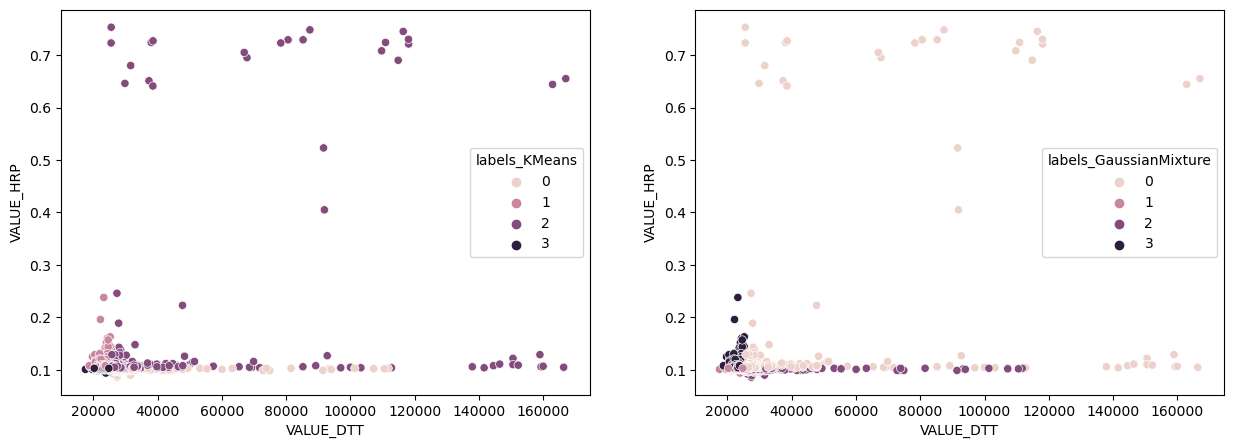

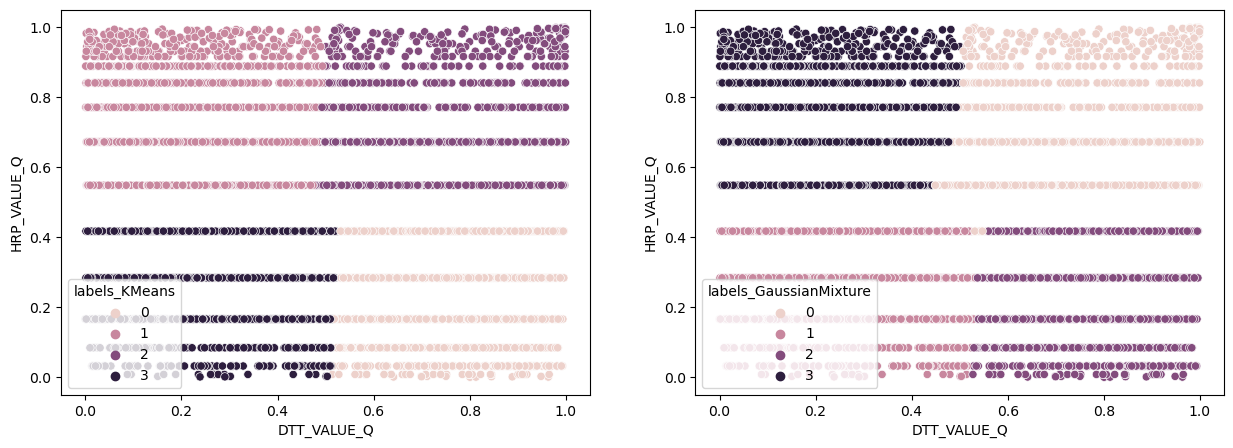

In [13]:
ss_scores_merged = pd.concat([combined_df, ss_results], axis=1)

fig, ax = plt.subplots(1, len(CLUSTERING_CONFIG), figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(ss_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue=f"labels_{config['name']}", ax=subplt)

fig, ax = plt.subplots(1, len(CLUSTERING_CONFIG), figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(ss_scores_merged, x="DTT_VALUE_Q", y="HRP_VALUE_Q", hue=f"labels_{config['name']}", ax=subplt)

In [14]:
summarize_clustering(ss_scores_merged[["VALUE_DTT", "VALUE_HRP"]].to_numpy(), ss_scores_merged[["labels_KMeans"]].to_numpy())

Cluster 0: 1245 values
	Mean: [2.84302153e+04 1.01323695e-01]
	Std: [7.31618598e+03 1.58115178e-03]
	Min: [2.5428e+04 8.6000e-02]
	Max: [1.11757e+05 1.03000e-01]

Cluster 1: 1347 values
	Mean: [2.36028649e+04 1.07550854e-01]
	Std: [1.22411279e+03 7.10005210e-03]
	Min: [1.8732e+04 1.0400e-01]
	Max: [2.5305e+04 2.3800e-01]

Cluster 2: 1106 values
	Mean: [3.07120118e+04 1.19622061e-01]
	Std: [1.70785102e+04 8.51752476e-02]
	Min: [2.5231e+04 1.0400e-01]
	Max: [1.67027e+05 7.53000e-01]

Cluster 3: 1054 values
	Mean: [2.39054962e+04 1.01551233e-01]
	Std: [1.21115057e+03 1.34359588e-03]
	Min: [1.7533e+04 9.4000e-02]
	Max: [2.5508e+04 1.0300e-01]



C:\Users\sbart\AppData\Local\Temp\ipykernel_12916\1454664559.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  kmeans_grouped = ss_scores_merged.groupby("labels_KMeans").mean()


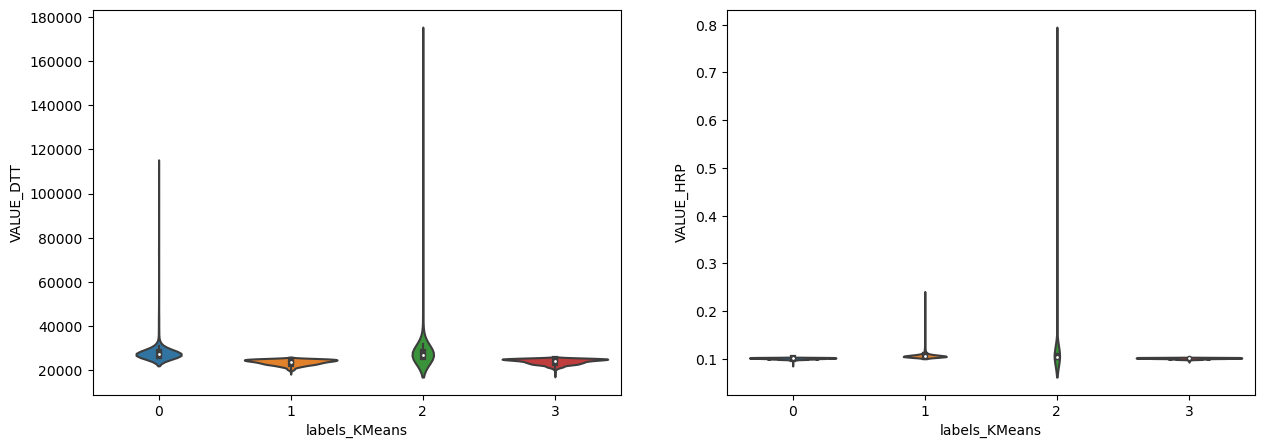

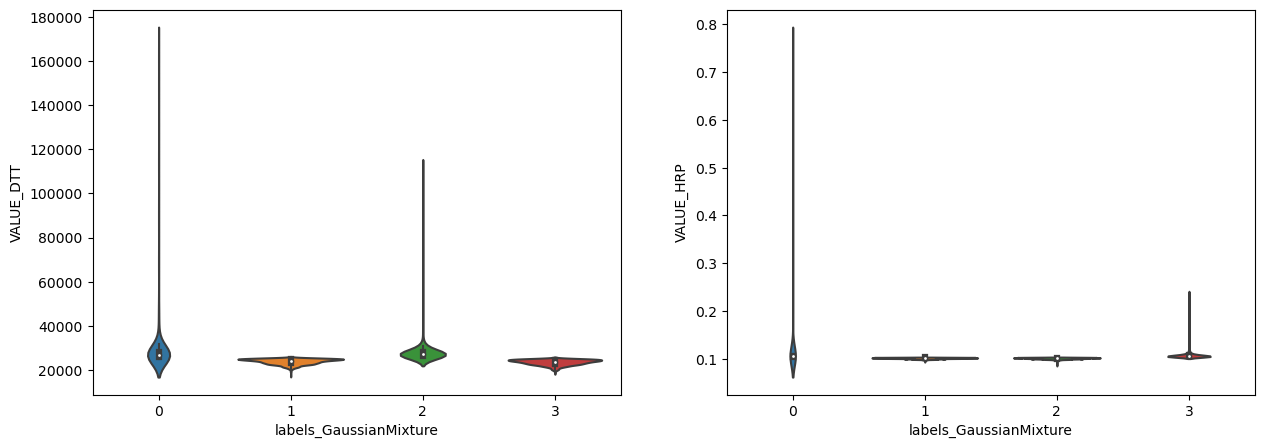

In [15]:
kmeans_grouped = ss_scores_merged.groupby("labels_KMeans").mean()
for config in CLUSTERING_CONFIG:
    fig, ax = plt.subplots(1, 2, figsize =(15, 5))
    sns.violinplot(ss_scores_merged, x="labels_"+config['name'], y="VALUE_DTT", ax=ax[0])
    sns.violinplot(ss_scores_merged, x="labels_"+config['name'], y="VALUE_HRP", ax=ax[1])

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


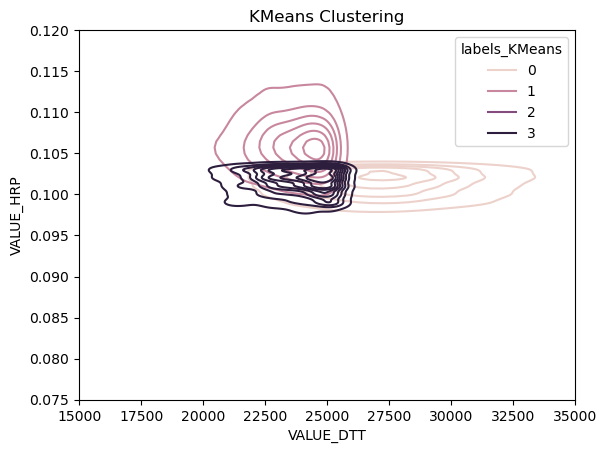

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


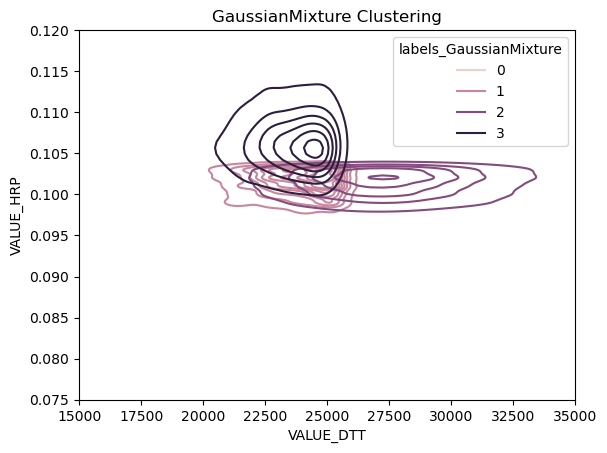

In [16]:
sns.kdeplot(ss_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue="labels_KMeans")
plt.xlim(15_000, 35_000)
plt.ylim(0.075, 0.12)
plt.title("KMeans Clustering")
plt.show()

sns.kdeplot(ss_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue="labels_GaussianMixture")
plt.xlim(15_000, 35_000)
plt.ylim(0.075, 0.12)
plt.title("GaussianMixture Clustering")
plt.show()

Percentage of ACTIVE samples by group


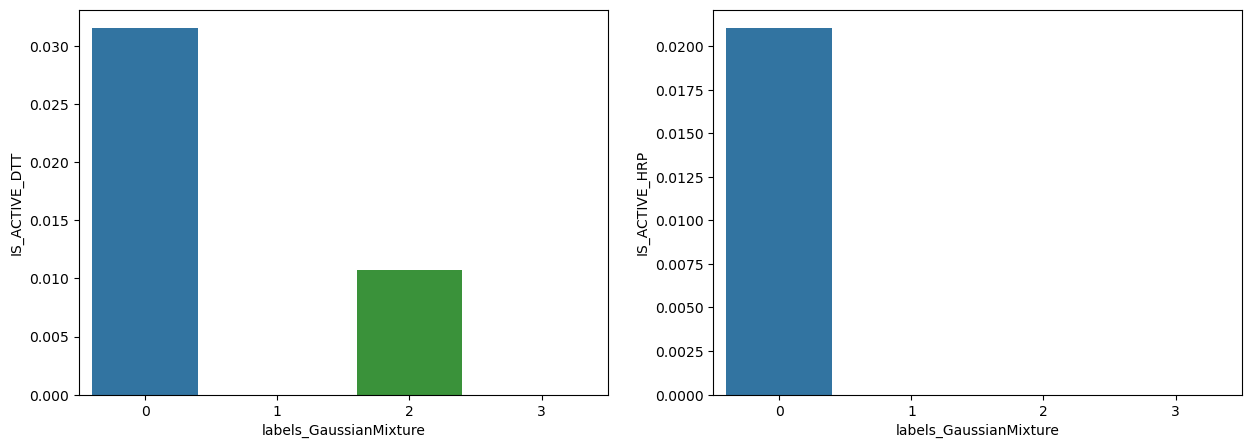

In [17]:
activity_mean_gs = ss_scores_merged.groupby("labels_GaussianMixture").mean(numeric_only=True)
activity_mean_km = ss_scores_merged.groupby("labels_KMeans").mean(numeric_only=True)

fig, ax = plt.subplots(1, 2, figsize =(15, 5))
sns.barplot(activity_mean_gs, x=activity_mean_gs.index, y="IS_ACTIVE_DTT", ax=ax[0])
sns.barplot(activity_mean_gs, x=activity_mean_gs.index, y="IS_ACTIVE_HRP", ax=ax[1])
print("Percentage of ACTIVE samples by group")

Percentage of ACTIVE samples by group


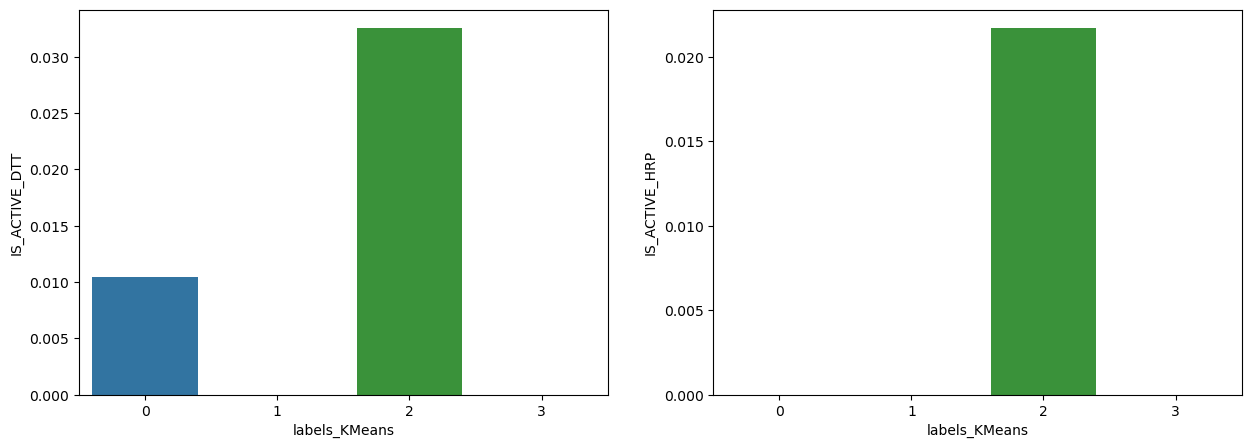

In [18]:
fig, ax = plt.subplots(1, 2, figsize =(15, 5))
sns.barplot(activity_mean_km, x=activity_mean_km.index, y="IS_ACTIVE_DTT", ax=ax[0])
sns.barplot(activity_mean_km, x=activity_mean_km.index, y="IS_ACTIVE_HRP", ax=ax[1])
print("Percentage of ACTIVE samples by group")

## Clustering results using Davies-Bouldin score

In [19]:
def negated_davies_bouldin(*args, **kwargs) -> float:
    return -metrics.davies_bouldin_score(*args, **kwargs)

db_results = evaluate_with_metric(value_series, negated_davies_bouldin, combined_df.index)

==== CLUSTERING WITH KMeans ====
Params: {'n_clusters': 2, 'random_state': 31} | Score: -1.0981896597707441
Params: {'n_clusters': 3, 'random_state': 31} | Score: -0.87518639069477
Params: {'n_clusters': 4, 'random_state': 31} | Score: -0.7667972036037152
Params: {'n_clusters': 5, 'random_state': 31} | Score: -0.8707001562856826
Params: {'n_clusters': 6, 'random_state': 31} | Score: -0.9474958726065874
Params: {'n_clusters': 7, 'random_state': 31} | Score: -0.8655739123018643
Params: {'n_clusters': 8, 'random_state': 31} | Score: -0.79824526296564
Params: {'n_clusters': 9, 'random_state': 31} | Score: -0.7747099081173359
Params: {'n_clusters': 10, 'random_state': 31} | Score: -0.8120961663268007
Params: {'n_clusters': 11, 'random_state': 31} | Score: -0.8442667716814849
Params: {'n_clusters': 12, 'random_state': 31} | Score: -0.8533521638223586
Params: {'n_clusters': 13, 'random_state': 31} | Score: -0.8188014782549554
Params: {'n_clusters': 14, 'random_state': 31} | Score: -0.78636342

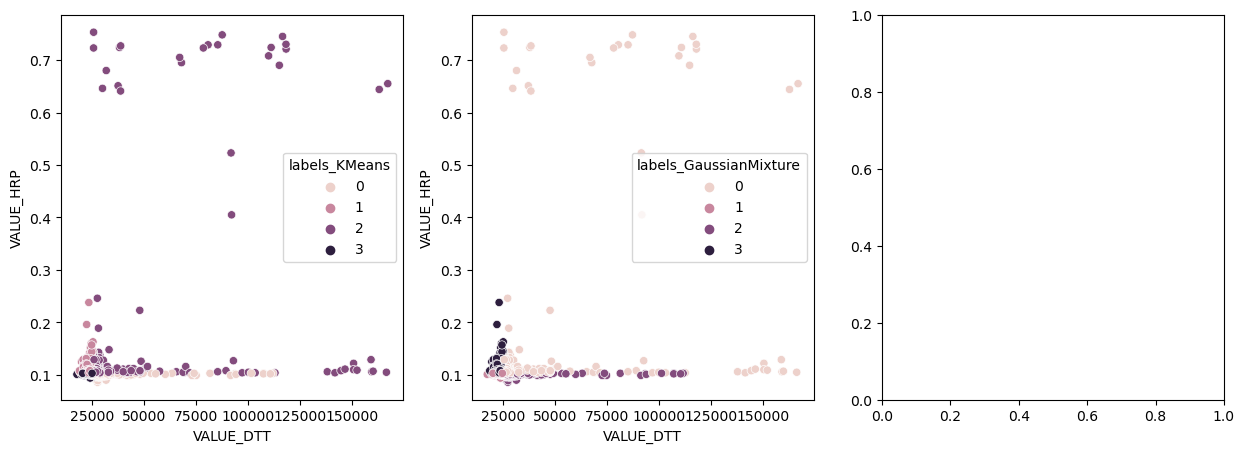

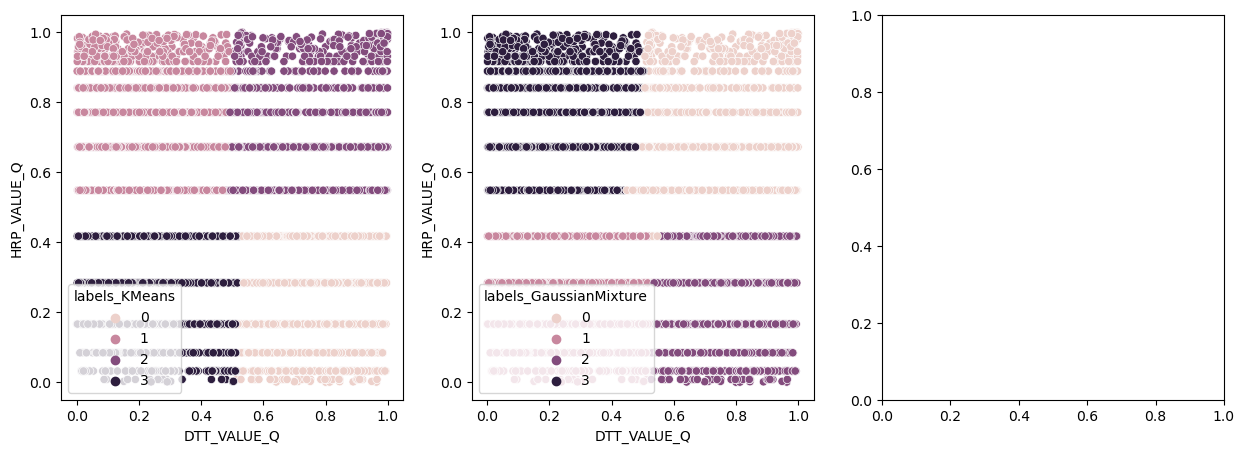

In [20]:
db_scores_merged = pd.concat([combined_df, db_results], axis=1)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(db_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue=f"labels_{config['name']}", ax=subplt)

fig, ax = plt.subplots(1, 3, figsize =(15, 5))
for config, subplt in zip(CLUSTERING_CONFIG, ax):
    sns.scatterplot(db_scores_merged, x="DTT_VALUE_Q", y="HRP_VALUE_Q", hue=f"labels_{config['name']}", ax=subplt)

In [21]:
summarize_clustering(ss_scores_merged[["VALUE_DTT", "VALUE_HRP"]].to_numpy(), ss_scores_merged[["labels_KMeans"]].to_numpy())

Cluster 0: 1245 values
	Mean: [2.84302153e+04 1.01323695e-01]
	Std: [7.31618598e+03 1.58115178e-03]
	Min: [2.5428e+04 8.6000e-02]
	Max: [1.11757e+05 1.03000e-01]

Cluster 1: 1347 values
	Mean: [2.36028649e+04 1.07550854e-01]
	Std: [1.22411279e+03 7.10005210e-03]
	Min: [1.8732e+04 1.0400e-01]
	Max: [2.5305e+04 2.3800e-01]

Cluster 2: 1106 values
	Mean: [3.07120118e+04 1.19622061e-01]
	Std: [1.70785102e+04 8.51752476e-02]
	Min: [2.5231e+04 1.0400e-01]
	Max: [1.67027e+05 7.53000e-01]

Cluster 3: 1054 values
	Mean: [2.39054962e+04 1.01551233e-01]
	Std: [1.21115057e+03 1.34359588e-03]
	Min: [1.7533e+04 9.4000e-02]
	Max: [2.5508e+04 1.0300e-01]



In [22]:
summarize_clustering(ss_scores_merged[["VALUE_DTT", "VALUE_HRP"]].to_numpy(), ss_scores_merged[["labels_GaussianMixture"]].to_numpy())

Cluster 0: 1140 values
	Mean: [3.05542421e+04 1.19120175e-01]
	Std: [1.68460049e+04 8.39436660e-02]
	Min: [2.5099e+04 1.0300e-01]
	Max: [1.67027e+05 7.53000e-01]

Cluster 1: 1070 values
	Mean: [2.39294112e+04 1.01542056e-01]
	Std: [1.21764278e+03 1.34220055e-03]
	Min: [1.7533e+04 9.4000e-02]
	Max: [2.5572e+04 1.0300e-01]

Cluster 2: 1207 values
	Mean: [2.85204341e+04 1.01298260e-01]
	Std: [7.41248465e+03 1.58405119e-03]
	Min: [2.5521e+04 8.6000e-02]
	Max: [1.11757e+05 1.03000e-01]

Cluster 3: 1335 values
	Mean: [2.35895768e+04 1.07597004e-01]
	Std: [1.22157649e+03 7.12158653e-03]
	Min: [1.8732e+04 1.0400e-01]
	Max: [2.537e+04 2.380e-01]



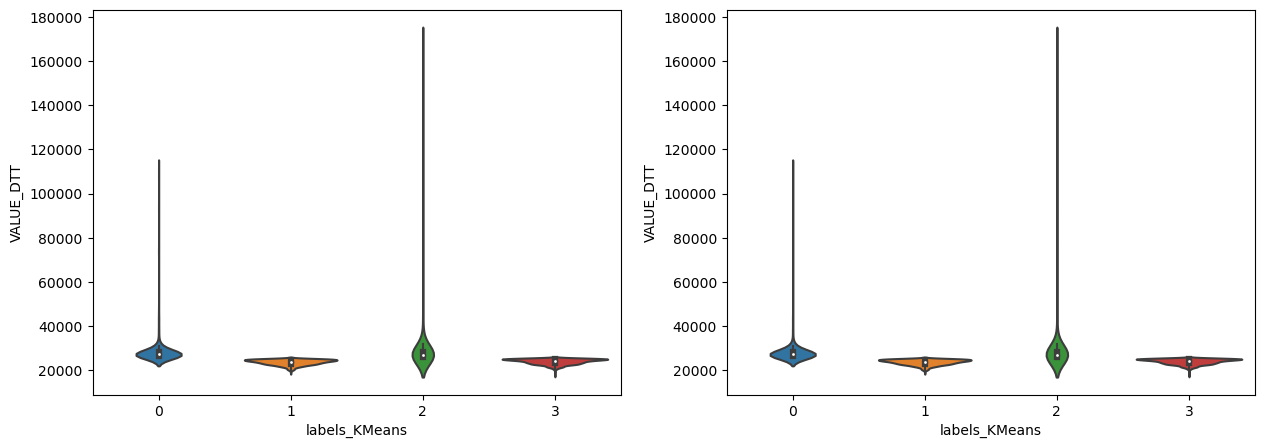

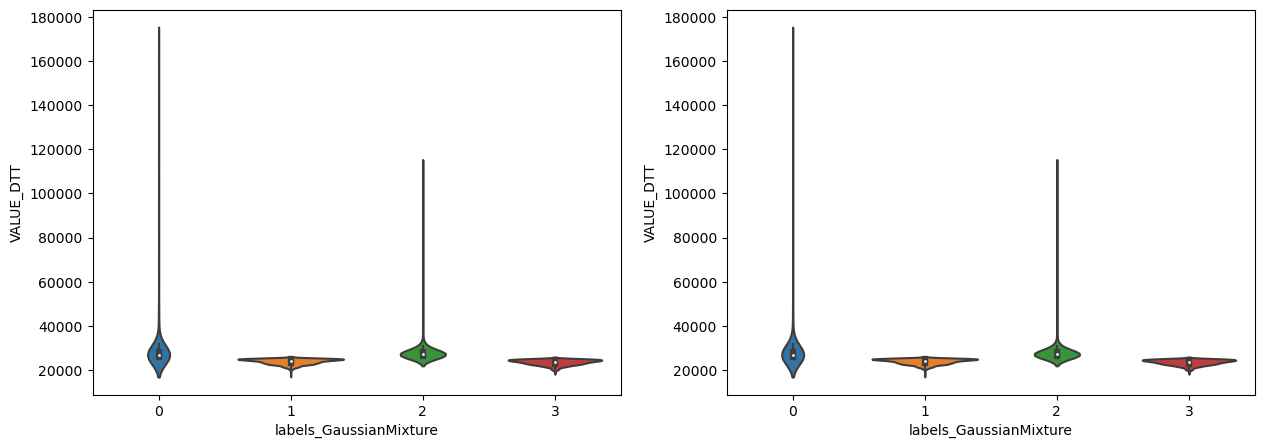

In [23]:
for config in CLUSTERING_CONFIG:
    fig, ax = plt.subplots(1, 2, figsize =(15, 5))
    sns.violinplot(db_scores_merged, x="labels_"+config['name'], y="VALUE_DTT", ax=ax[0])
    sns.violinplot(db_scores_merged, x="labels_"+config['name'], y="VALUE_DTT", ax=ax[1])

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


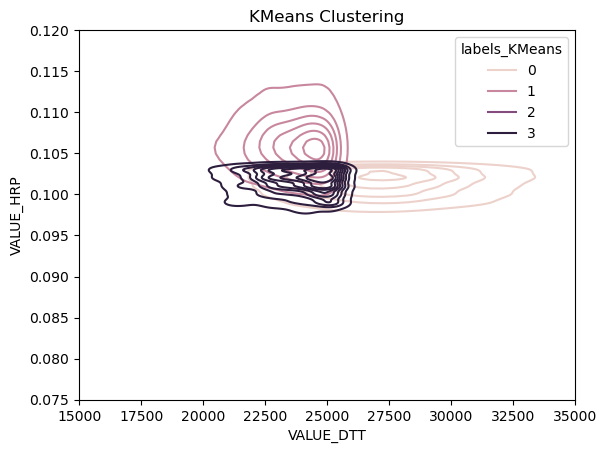

d:\Programs\Anaconda\envs\drug-screening\lib\site-packages\seaborn\distributions.py:1191: UserWarning: No contour levels were found within the data range.
  cset = contour_func(


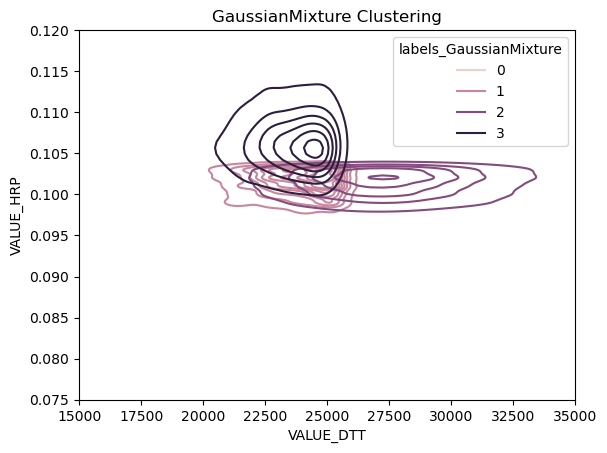

In [24]:
sns.kdeplot(db_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue="labels_KMeans")
plt.xlim(15_000, 35_000)
plt.ylim(0.075, 0.12)
plt.title("KMeans Clustering")
plt.show()

sns.kdeplot(db_scores_merged, x="VALUE_DTT", y="VALUE_HRP", hue="labels_GaussianMixture")
plt.xlim(15_000, 35_000)
plt.ylim(0.075, 0.12)
plt.title("GaussianMixture Clustering")
plt.show()

Percentage of ACTIVE samples by group


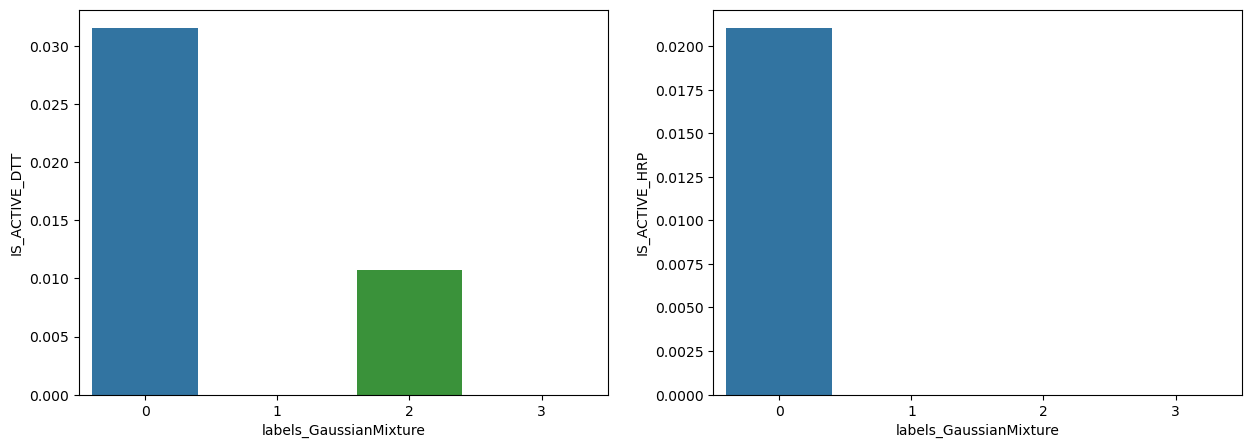

In [25]:
activity_mean_gs = db_scores_merged.groupby("labels_GaussianMixture").mean(numeric_only=True)
activity_mean_km = db_scores_merged.groupby("labels_KMeans").mean(numeric_only=True)

fig, ax = plt.subplots(1, 2, figsize =(15, 5))
sns.barplot(activity_mean_gs, x=activity_mean_gs.index, y="IS_ACTIVE_DTT", ax=ax[0])
sns.barplot(activity_mean_gs, x=activity_mean_gs.index, y="IS_ACTIVE_HRP", ax=ax[1])
print("Percentage of ACTIVE samples by group")

Percentage of ACTIVE samples by group


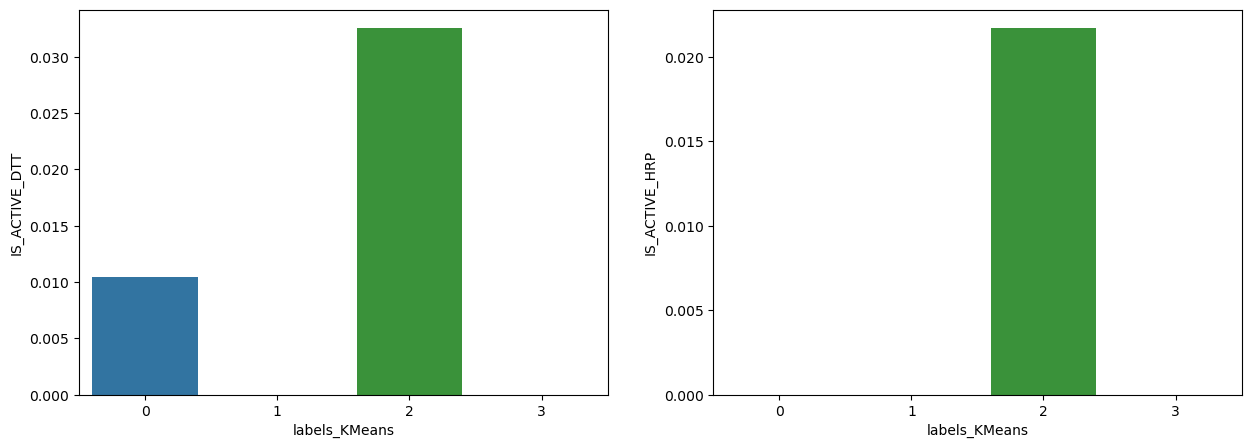

In [26]:
fig, ax = plt.subplots(1, 2, figsize =(15, 5))
sns.barplot(activity_mean_km, x=activity_mean_km.index, y="IS_ACTIVE_DTT", ax=ax[0])
sns.barplot(activity_mean_km, x=activity_mean_km.index, y="IS_ACTIVE_HRP", ax=ax[1])
print("Percentage of ACTIVE samples by group")

# Activities Correlation

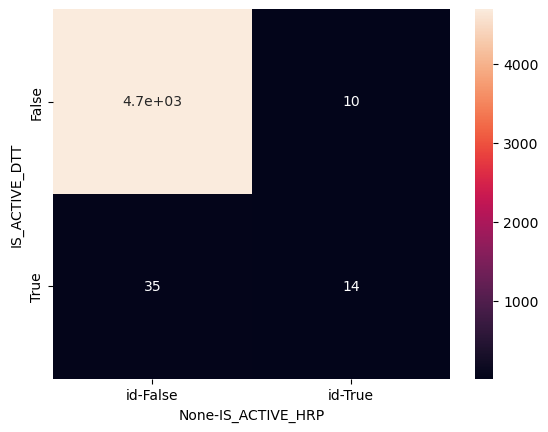

In [27]:
pivoted_df = combined_df[["IS_ACTIVE_DTT", "IS_ACTIVE_HRP", "id"]].groupby(["IS_ACTIVE_DTT", "IS_ACTIVE_HRP"]).count().reset_index().pivot(index="IS_ACTIVE_DTT", columns="IS_ACTIVE_HRP")
sns.heatmap(pivoted_df, annot=True)
plt.show()